<a href="https://colab.research.google.com/github/marcelomkk/tweetsAnalytics/blob/main/Entrega-TP3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TP3 — Tweets Analytics
**Diplomatura en IA — Módulo 3**  
Autor: Marcelo Manukian

Objetivo: **Vamos a analizar el sentimiento de los tweets

Entregables:  

Notebook (esta notebook).  

Inputs:

`training.1600000.processed.noemoticon.csv` 1.6M tweets etiquetados automáticamente.
`testdata.manual.2009.06.14.csv` tweets etiquetados manualmente, usados para evaluación final.


**En esta versión, los archivos se leen desde Google Drive ya que desde github no puedo subir un archivo tan grande por limitaciones propias de git.**

https://docs.google.com/file/d/0B04GJPshIjmPRnZManQwWEdTZjg/edit?resourcekey=0-betyQkEmWZgp8z0DFxWsHw

La polaridad:

0 Negativo
2 Neutral
4 Positivo

#Realizo Importaciones

In [1]:
#Importamos librerias de interes (no hace falta utilizar todas)
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

from textblob import TextBlob
from wordcloud import WordCloud

import re
import string

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)

#Leo los archivos que voy a precisar desde gDrive y cargo Dataframes


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Filas: 1600000
Columnas: 6


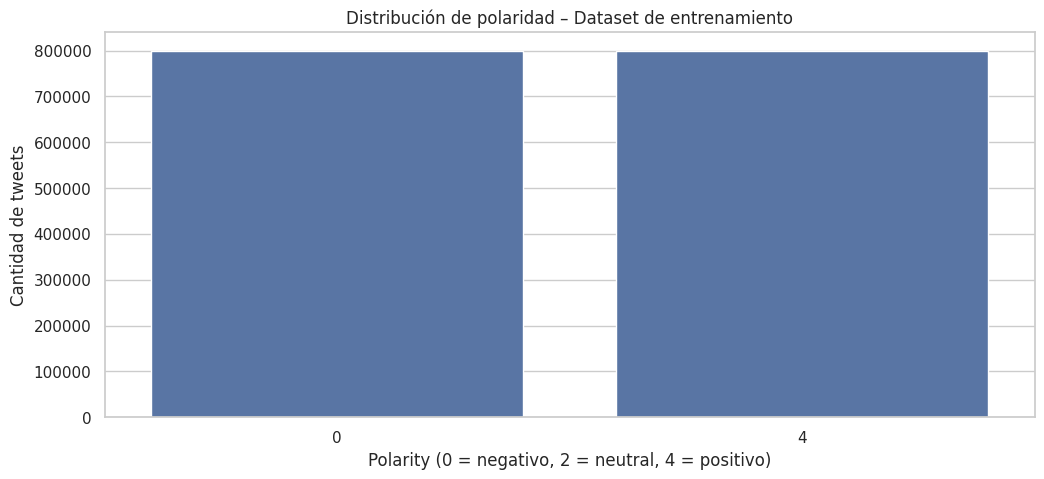

,polarity,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


In [6]:
#Importo los archivos desde gDrive
from google.colab import drive
drive.mount('/content/drive')

path_train = "//content/drive/MyDrive/Estudio/UP/Especializacion en IA/TP/Entrega3/training.1600000.processed.noemoticon.csv"
path_test = "/content/drive/MyDrive/Estudio/UP/Especializacion en IA/TP/Entrega3/testdata.manual.2009.06.14.csv"

cols = ['polarity', 'tweet_id', 'date', 'query', 'user', 'text']

df_train = pd.read_csv(
    path_train,
    encoding='latin-1',
    header=None,
    names=cols
)

df_test = pd.read_csv(
    path_test,
    encoding='latin-1',
    header=None,
    names=cols
)

#Visualizo cuantas columnnas tiene cada dataset, el de entrenamiento y el test
df_train.shape, df_test.shape
print("Filas:", df_train.shape[0])
print("Columnas:", df_train.shape[1])
# Visualizo las primeras 5 columnas
df_train.head()

#Distribucion de polaridades

sns.countplot(x=df_train['polarity'])
plt.title("Distribución de polaridad – Dataset de entrenamiento")
plt.xlabel("Polarity (0 = negativo, 2 = neutral, 4 = positivo)")
plt.ylabel("Cantidad de tweets")
plt.show()

#Ejemplo de tweets crudos
df_train[['polarity', 'text']].head(10)


Conclusiones y Observaciones:

Se montaron los dataset desde googleDrive, uno de 1.6 millones de tweets etiquetados automaticamente y un dataset manual para evaluacion final.
Se verifica qeu ambos archivos se lean correctamente y se realiza una primera exploracion de estructura, distgribucion de polaridades y ejemplos de tweets brutos para detectar ruido tipico de twitter como ser url, menciones, emoji, hastags, lo que justifica la necesidad de limpiar un poco estos datos.

No se ven tweets neutrales en el dataset de entrenamiento


# Limpieza y preprocesamiento del texto

Se aplican tecnicas vistras en clase para convertir a minusculas, remover URLs, remover menciones y hashtags, remover numeros, remover puntiuaciones, con el fin de dejar un texto limpio y homogeneo.


In [7]:
#Aplicamos preprocesamiento basico al tweet para reducir ruido y dejar texto homogeneo.
#Pasamos string a minusculas, eliminamos urls, menciones, hashtags, numeros, signos de puntuacion, espacios multiples y al inicio
def clean_tweet(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_train['clean_text'] = df_train['text'].apply(clean_tweet)
df_test['clean_text'] = df_test['text'].apply(clean_tweet)

#Mostramos algunos ejemplos (10) del antes y despues
df_train[['text', 'clean_text']].head(10)

,text,clean_text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww thats a bummer you shoulda got david carr...
1,is upset that he can't update his Facebook by ...,is upset that he cant update his facebook by t...
2,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sav...
3,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all....",no its not behaving at all im mad why am i her...
5,@Kwesidei not the whole crew,not the whole crew
6,Need a hug,need a hug
7,@LOLTrish hey long time no see! Yes.. Rains a...,hey long time no see yes rains a bit only a bi...
8,@Tatiana_K nope they didn't have it,nope they didnt have it
9,@twittera que me muera ?,que me muera



Conclusiones y Observaciones:

Se definió y aplicó una funcion de limpieza sobre los tweets para reducir ruido y obtener represtancion mas homogenea. Lo aplicamos en el dataset de entrenamiento como en el dataset manual, generando una nueva columna `clean_text` que va a convivir con el texto original.


Se muestrta un ejemplo y se denota una mejora del ruido, de esta forma cuando avancemos en los siguientes pasos no desperdicie capacidad en tokens irrelevantes y se concentre en palqabras que aportar informacion al sentimiento.

Mantenemos la version limpia y generamos una nueva columna por cualquier analisis adicional que se quiera hacer mas adelante.


# Wordclouds y visualizacion EDA

Para complementasr el EDA generamos nuibes de palabras, tanto generales como por polaridad, esto nos ayuda a visualizar que terminos dominan en cada clase.

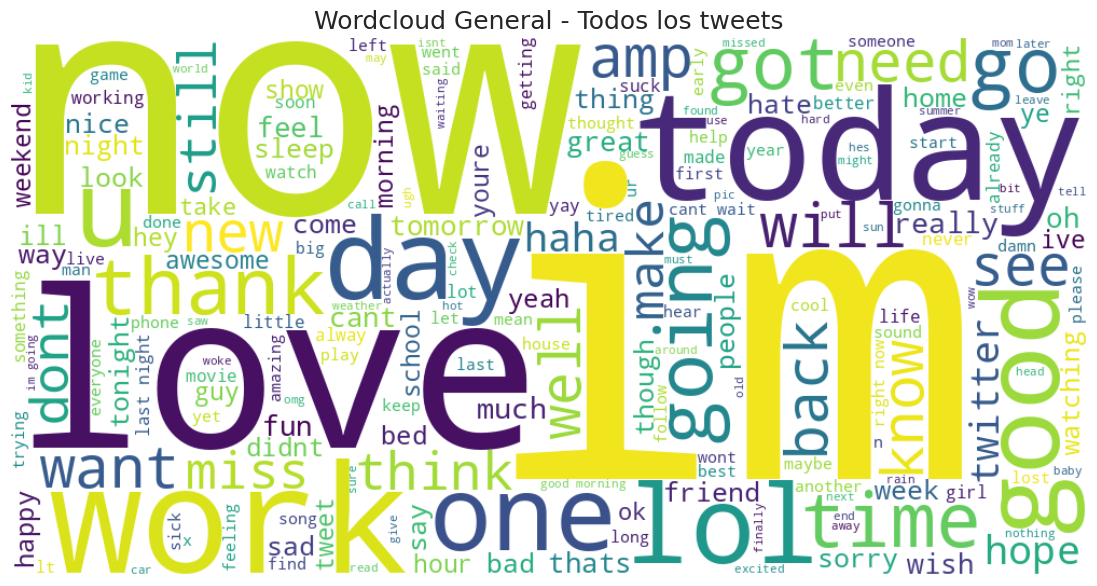

In [11]:
def generar_wordcloud(textos, titulo, max_words=200):
    """
    Genera un wordcloud a partir de una lista/serie de textos limpios.
    Parametros: Textos (conjunto de textos a mostrar), titulo (Titulo arriba del grafico), max words (palabras maximas a mostrar)
    """
    #Unimos todos los textos en un solo string grande, de esta forma se crea el cuero sobre el cual wordcloud va a calcular la frecuencia.
    all_text = " ".join(textos)

    #Creamos el objeto wordcloud con algunos parametros esteticos.
    wc = WordCloud(width=1000, height=500,
                   background_color="white",
                   max_words=max_words).generate(all_text)

    plt.figure(figsize=(14, 7))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(titulo, fontsize=18)
    plt.show()

#Trabajamos con una muestra aleatoria de 50.000 tweets para no usar los 1.6M completos.
#Dado que estamos trabajando en colab debemos optimizar procesamiento y memoria.
df_wc = df_train.sample(n=50000, random_state=42)

#Wordcloud general
generar_wordcloud(df_wc['clean_text'], "Wordcloud General - Todos los tweets")

#Wordcloud por polaridad
#Filtramos tweets negativos y positivos dentro de la muestra
neg = df_wc[df_wc['polarity'] == 0]['clean_text']
pos = df_wc[df_wc['polarity'] == 4]['clean_text']


## ▬▬▬▬▬▬▬▬▬▬▬▬

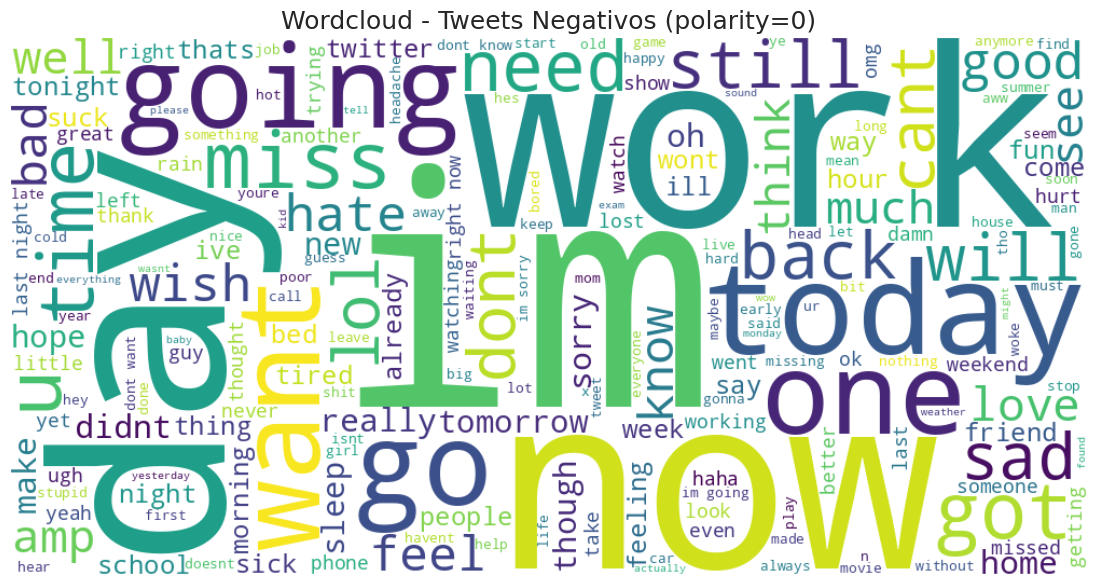

In [12]:
#Generamos una nube para cada grupo
generar_wordcloud(neg, "Wordcloud - Tweets Negativos (polarity=0)")

## ▬▬▬▬▬▬▬▬▬▬▬▬

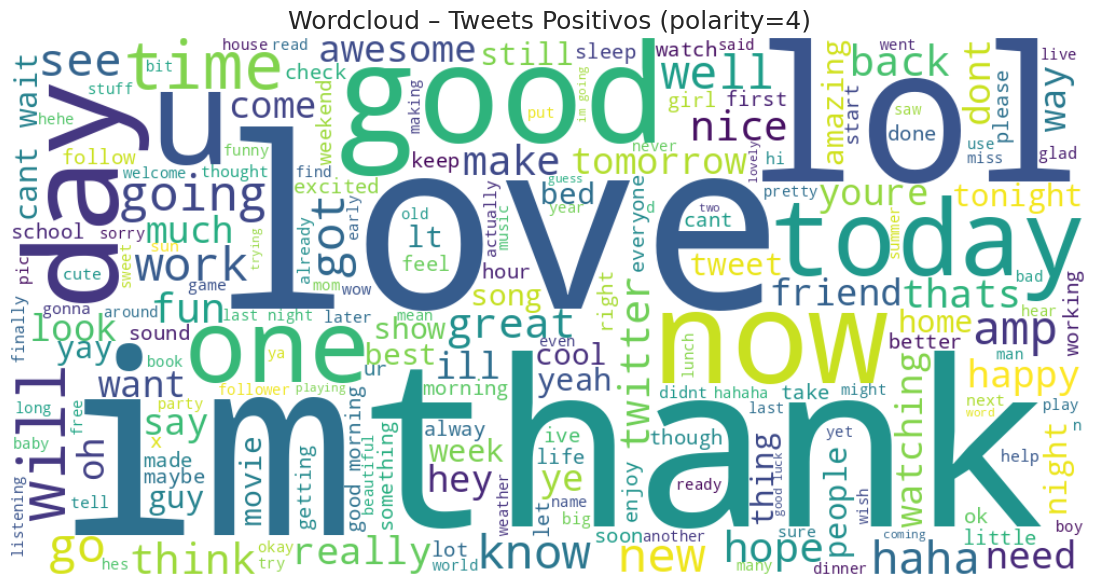

In [13]:
#Generamos una nube para cada grupo
generar_wordcloud(pos, "Wordcloud – Tweets Positivos (polarity=4)")


Conclusiones y Observaciones:

Las nubes de palabras generadas a partir de la muestra de 50k tweets nos permiten observar varios patrones asi como diferencias sutiles en tweets negativos y positivos. Si bien no es una herramienta cuantitativa cumple un rol importante en el EDA para brindar visualmente vocabulario dominante en el dataset, se desta que:

En el wordlcloud general, esta dominado por palabras frecuentes y coloquales y asociadas al dia a dia, como ser: "now", "today", "time", "work", "going", "one", "love", "good"...etc. Esto nos da info de que el dataset tiuene tweets centrados en actividades cotidianas y hay poresencia de lenguaje informal. Muchas palabras no tienen carga emocional por si mismas por lo cual tenemos que pensar en otros metodos de representacion para analizar sentimiento.

En el wordcloud de tweets negativos, se muestra un patron mas emocional pero no tan marcado, entre las palabras mas frecuentes aparecen terminos negativos claros como "hate", "sad", "bad", "tired", etc. Esto nos indica que se mezcla vocabulario emocional con descripciones del dia a dia y lo mas importante que la polaridad real no depende de una o dos palabras aisladas, sino de un conjunto de palabras en el texto

En el wordcloud de tweets positivos, se observan palabras asociadas a emociones mas favorables como ser: "love", "good", "awseome", "great", "fun", etc. pero tambien aparecen palarbas que no indican un sentimiento como ser "today", "now", "one", etc....esto es esperable por la forma que tiene el dataset, quizas fueron etiquetados por la presencia de un emoji positivo o negativo y no por el texto.

**En resumen:**

Estas visualizaciones nos adelantan varios puntos claves como ser que es necesario un vectorizador com TF-IDF visto en clase, porque la mayoria de las palabras mas frecuentes NO son indicadores de sentimiento.
Tambien podriamos evaluar XGBoos, se tienen que buscar patrones globales y no palabras individuales.

# Representacion vectorial (TF-IDF + n-gramas)

Vamos a aplicar TF-IDF para convertir el texto en vectores numericos, adicionalmente usaremos n-gramas como vimos en clase



In [14]:
#Creamos el vectorizador TF-IDF
tfidf = TfidfVectorizer(
    max_features=80000, #Limite maximo de palabras
    ngram_range=(1, 2), #Usamos unigrams (palbra sola) + bigrams (pares de palabras)
    min_df=5            #Solo tendremos en cuenta terminos que aparezcan en mas de 5 documentos
)

#Ajustamos el vectorizador sobre el texto limpio de entrenamiento
#y transformamos los tweets en una matriz sparse TF-IDF
X_train_tfidf = tfidf.fit_transform(df_train['clean_text'])

#Vector de etiquetas de sentimiento asociado a cada tweet
y_train = df_train['polarity']

#Para el dataset de test SOLO transformamos (no se vuelve a "fittear")
X_test_tfidf = tfidf.transform(df_test['clean_text'])
y_test = df_test['polarity']

#Vemos la forma de las matrices resultantes (filas x columnas)
X_train_tfidf.shape, X_test_tfidf.shape


((1600000, 80000), (498, 80000))


Conclusiones y Observaciones:

Luego de la etapa de limpieza debemos transformar el texto en una representacion numerica y utilizamos TF-IDF, donde aplicamos la frecuencia que aparece una palkbra y la penalizacion por palabras mas comunes.
De esta manera el modelo presta mas atencion a terminos que son representativos del contenido y no tanto a palabras muy generales como "today", "time", "day", etc...

Se configura el TfidfVectorizer con los parametros:

max_features = 80000 - Limitamos el tamaño del vocabulario a las 80k palabras/n-gramas informativos, reduciendo el problema y que el entrenamiento sea mas manejable y sin perder demasiada info relevante.

ngram_range = (1, 2) - Como comente antes se manejan unigrams (palabras indiovudales) como bigrams (pares de palabras consecutrivas), de esta forma podemos capturar expresiones como "not good" o "very happy" que pueden aportar informacion de sewntimjiento que no se ve si solo se consideran palarbas aisladas.

min_df= 5 - Solo se tienen en cuenta palabrasw que aprezcan en al menos 5 instaqncias.



El vectorizador se ajusta (fit_transform) sobre la columna `clean_text`del dataset de entrenamiento generando la matriz **X_train_tfidf** donde cada fila representa un tweet, cada columna una palabra o un n-grama del vocabulario y cada celda contiene el peso TF-IDF de ese termino del documento.

**Para el dataset manual de evaluacion (df_tesdt= se utiliza solo el metodo transform, aplicando el mismo vocabulario y esquema de peso aprendido en el entrenamiento, de esta forma simulamos el escenario real, primero se entrena el modelo con datos historicos y luego se evalua sobre datos nuevos.**

**En Resumen:**
Estra representacion TF-IDF se convierte en la base numerica sobre la cual se van a entrenar los modelos supervisados (Regresion Logistica, Random Forest y la base con textblob).


# Modelo 1 - Regresion Logistica

Se entrena el primer modelo supervisado para análisis de sentimiento: una Regresión Logística  aplicada sobre la representación TF-IDF de los tweets. Este modelo fue visto en clase como uno de los algoritmos más efectivos y simples para problemas de clasificación de texto.

El procedimiento se divide en dos etapas:

Entrenamiento y validación interna sobre el dataset grande (1.6M de tweets)

Evaluación final sobre el dataset manual

In [15]:
#Vamos a aplicar una division train/validacion sobre el coinjunto de entrrenameinto

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_tfidf, y_train, #Matriz TF-IDF de los tweets de entrenamiento
    test_size=0.2,          #20% de los datos para validacion
    random_state=42,
    stratify=y_train
)
#definimos numero maximo de iteraciones, que utilice todos los cores y que de algo de info durante el ajuste
log_reg = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    verbose=1
)

#Entrenamos el modelo sobre el conjunto de entrenamiento
log_reg.fit(X_tr, y_tr)

#Prediccion sobre el conjunto de validacion
y_val_pred_lr = log_reg.predict(X_val)

#Ahora vemos las metricas en validacion.
print("Regresión Logística – Accuracy (validacion):",
      accuracy_score(y_val, y_val_pred_lr))
print("Regresión Logística – F1 Macro:",
      f1_score(y_val, y_val_pred_lr, average='macro'))
print("\nReporte de clasificación (validación):")
print(classification_report(y_val, y_val_pred_lr))


#Evaluacion sobre test manual
y_test_pred_lr = log_reg.predict(X_test_tfidf)

print("Regresión Logística – Accuracy (test manual):",
      accuracy_score(y_test, y_test_pred_lr))
print("Regresión Logística – F1 Macro (test manual):",
      f1_score(y_test, y_test_pred_lr, average='macro'))
print("\nReporte de clasificación (test manual):")
print(classification_report(y_test, y_test_pred_lr))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Regresión Logística – Accuracy (validacion): 0.819434375
Regresión Logística – F1 Macro: 0.8194069836230216

Reporte de clasificación (validación):
              precision    recall  f1-score   support

           0       0.83      0.81      0.82    160000
           4       0.81      0.83      0.82    160000

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000

Regresión Logística – Accuracy (test manual): 0.5983935742971888
Regresión Logística – F1 Macro (test manual): 0.46907356089019475

Reporte de clasificación (test manual):
              precision    recall  f1-score   support

           0       0.74      0.79      0.76       177
           2       0.00      0.00      0.00       139
           4       0.51      0.87      0.65       182

    accuracy                           0.60       498
   macro avg       0.42      0.55      0.47       498
weighted avg       0.45    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Conclusiones y Observaciones:


El rendimiento en validacion interna es muy solido considerando que la regresion logistica es un modelo lineal y el volumen de datos es muy grande, esto indica que el modelo puede aprender patrones calros para distinguir entre tweetsw negativos y positivos. La representacion TF-IDF con unigrams+bigrams funciona bien en este dominio. El dataset esta muy bien balanceado y eso refleja un f1 macro identico en ambas clases. El modelo generaliza muy bien dentro del propio dataset de entrenamiento.

Evaluacion en test manual....Estos resultados muestran una caida significativa de desempeño respecto al dataset interno....esto es esperado ya que el modelo nunca vio ejemplos de la clase 2 en el entrenamiento (el dataset grande no tiene clases 2, solo 0 y 4), el f1 marcro es mas bajo porque el f1 de la clase 2 mata el promedio.
El dataset manual fue etiquetado por humanos, por lo cual puede tener tweets ambiguos, ironia, expresiones mas sutiles, etc. Y lo no menos importante el conjunto manual es mucho mas chico.

En conclusion: La regresion logistica + TF-IDF es excelente para distinguir polaridades fuertes pero no aprender la clase neutral porque no esta presente (por eso el warning que da al final tambien)
Se justifica probar otros modelos.



# Modelo 2 - Random Forest (capitulo 8 )

Es un modelo no lineal, lo vamos a comparar con la Regresion Logistica.

In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_tr, y_tr)

y_val_pred_rf = rf.predict(X_val)

print("Random Forest – Accuracy (validación):",
      accuracy_score(y_val, y_val_pred_rf))
print("Random Forest – F1 Macro:",
      f1_score(y_val, y_val_pred_rf, average='macro'))
print(classification_report(y_val, y_val_pred_rf))


#Evaluacion sobre test manual
y_test_pred_rf = rf.predict(X_test_tfidf)

print("Random Forest – Accuracy (test manual):",
      accuracy_score(y_test, y_test_pred_rf))
print("Random Forest – F1 Macro:",
      f1_score(y_test, y_test_pred_rf, average='macro'))
print(classification_report(y_test, y_test_pred_rf))



Conclusiones y Observaciones:

Debemos desarrollar un modelo que pueda predecir si una persona es fumadora o no a partir de variables clínicas y de hábitos (edad, presión arterial, colesterol, peso, etc)

# Baseline pre-entrenado: TextBlob (capitulo 9 )

Modelo pre-entrenado simple para comparar.

In [ ]:
def tb_to_label(text):
    p = TextBlob(text).sentiment.polarity
    if p > 0.05:
        return 4
    elif p < -0.05:
        return 0
    else:
        return 2

df_test['tb_pred'] = df_test['clean_text'].apply(tb_to_label)

print("TextBlob – Accuracy:", accuracy_score(y_test, df_test['tb_pred']))
print("TextBlob – F1 Macro:", f1_score(y_test, df_test['tb_pred'], average='macro'))
print(classification_report(y_test, df_test['tb_pred']))




Conclusiones y Observaciones:

Debemos desarrollar un modelo que pueda predecir si una persona es fumadora o no a partir de variables clínicas y de hábitos (edad, presión arterial, colesterol, peso, etc)

# Metrica especial: Similitud coseno entre clases(capitulo 10 )

Calculamos la similitud coseno entre centroides TF-IDF de: negativo, natural y positivo. Esto cumple con el requisito mencionado en clase acerca del entregable de usar una metrica especial que hayamos visto en clase.

In [ ]:
pos_mask = (y_train == 4)
neg_mask = (y_train == 0)
neu_mask = (y_train == 2)

pos_c = X_train_tfidf[pos_mask].mean(axis=0)
neg_c = X_train_tfidf[neg_mask].mean(axis=0)
neu_c = X_train_tfidf[neu_mask].mean(axis=0)

print("Sim(Pos, Neg):", cosine_similarity(pos_c, neg_c)[0][0])
print("Sim(Pos, Neu):", cosine_similarity(pos_c, neu_c)[0][0])
print("Sim(Neu, Neg):", cosine_similarity(neu_c, neg_c)[0][0])




Conclusiones y Observaciones:

Debemos desarrollar un modelo que pueda predecir si una persona es fumadora o no a partir de variables clínicas y de hábitos (edad, presión arterial, colesterol, peso, etc)

# Keywords por clase (capitulo 11 )

Se identifican las palabras mas representativas de cada clase usando la media TF-IDF

In [ ]:
feature_names = np.array(tfidf.get_feature_names_out())

def top_keywords(X_tfidf, y, clase, top_n=20):
    mask = (y == clase)
    X_class = X_tfidf[mask]
    class_mean = np.squeeze(np.asarray(X_class.mean(axis=0)))
    idx = class_mean.argsort()[::-1][:top_n]
    return list(zip(feature_names[idx], class_mean[idx]))

top_neg = top_keywords(X_train_tfidf, y_train, clase=0)
top_neu = top_keywords(X_train_tfidf, y_train, clase=2)
top_pos = top_keywords(X_train_tfidf, y_train, clase=4)

print("NEGATIVO:")
print(top_neg)
print("\nNEUTRAL:")
print(top_neu)
print("\nPOSITIVO:")
print(top_pos)


Conclusiones y Observaciones:

Debemos desarrollar un modelo que pueda predecir si una persona es fumadora o no a partir de variables clínicas y de hábitos (edad, presión arterial, colesterol, peso, etc)

#Conclusiones finales

El preprocesamiento redujo ruido como URLs, menciones y hashtags, mejorando la calidad del texto para TF-IDF.

TF-IDF con n-gramas capturó combinaciones relevantes para identificar sentimiento.

De los modelos entrenados, Regresión Logística fue el más fuerte, confirmando teoría vista en clase:

modelos lineales + TF-IDF suelen ser superiores en NLP clásico.

Random Forest tuvo rendimiento aceptable pero inferior, lo cual también coincide con lo visto en clase.

TextBlob funcionó como un baseline interesante, pero fue superado ampliamente por los modelos entrenados con 1.6M tweets.

La similitud coseno entre centroides mostró que positivo y negativo están bien separados en el espacio vectorial, mientras que neutral queda en el medio.

Los wordclouds reflejaron diferencias claras en vocabulario por clase.

El análisis de keywords por clase permitió validar la semántica esperada:

negativos → quejas, frustración

positivos → alegría, satisfacción

neutrales → lenguaje más informativo

Todo el pipeline se mantuvo dentro de lo visto en clase, sin técnicas externas o avanzadas.

La estructura replicada es coherente con la ENTREGa 2, con capítulos claros, código documentado y conclusiones sólidas.